In [2]:
import sys
import os
import glob 

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sc

import plotly.express as px
import plotly.graph_objects as go

import collections

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

import tensorflow as tf
from sklearn.preprocessing import StandardScaler

2025-10-31 11:19:09.379617: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-31 11:19:10.635177: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-31 11:19:14.379303: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


key question:
- time series and other features? 

In [3]:
derived_path = "/cluster/home/taoj/work_dir/eth-capstone/tree-water-deficit/data"
data_dir = "/cluster/home/taoj/work_dir/eth-caipstone/tree-water-deficit/data/tstoy04"

In [4]:
df_series_all = pd.read_csv(os.path.join(derived_path, "twd_tree_series_all.csv"))
twd_tree_series_sites = pd.read_csv(os.path.join(derived_path, "twd_tree_series_sites.csv"))

In [5]:
df_series_all.head(10)
# twd_tree_series_sites.head(10)

,ts,twd,pr,at,ws,dp,sr,lr,series,site_name,species,series_no,Wt,year,month,year_month
0,2020-01-01,0.000000,-4.967054e-09,0.684757,1.197186,-3.640214,62.291590,212.325577,series_06,Bachtel-Forest,Fagus sylvatica,1,NaN,2020,1,2020-01
1,2020-01-02,0.121408,-1.092752e-07,0.213088,1.312338,-4.036302,60.923900,219.828021,series_06,Bachtel-Forest,Fagus sylvatica,1,0.121408,2020,1,2020-01
2,2020-01-03,0.118271,1.285767e-01,2.009851,2.115951,-0.953911,55.859708,275.925156,series_06,Bachtel-Forest,Fagus sylvatica,1,-0.003137,2020,1,2020-01
3,2020-01-04,0.000000,9.927122e-02,1.573278,3.247398,0.721803,13.914832,311.878969,series_06,Bachtel-Forest,Fagus sylvatica,1,-0.118271,2020,1,2020-01
4,2020-01-05,0.000000,-1.986821e-08,-0.442240,2.159941,-4.094125,62.620516,216.038632,series_06,Bachtel-Forest,Fagus sylvatica,1,0.000000,2020,1,2020-01
5,2020-01-06,0.000000,3.880511e-10,1.900865,1.479226,-5.472837,63.572741,220.306782,series_06,Bachtel-Forest,Fagus sylvatica,1,0.000000,2020,1,2020-01
6,2020-01-07,0.593406,2.411429e-02,1.480216,2.514120,-1.105571,26.014536,265.315427,series_06,Bachtel-Forest,Fagus sylvatica,1,0.593406,2020,1,2020-01
7,2020-01-08,0.557187,-6.457170e-07,3.140700,2.099829,-7.224881,48.464034,265.264362,series_06,Bachtel-Forest,Fagus sylvatica,1,-0.036220,2020,1,2020-01
8,2020-01-09,0.918142,-1.182159e-06,5.119999,1.631017,-5.251706,58.383674,248.506977,series_06,Bachtel-Forest,Fagus sylvatica,1,0.360955,2020,1,2020-01
9,2020-01-10,1.269509,5.132516e-03,3.655803,3.022984,-0.587912,39.215077,289.792323,series_06,Bachtel-Forest,Fagus sylvatica,1,0.351367,2020,1,2020-01


start from simple model 
- understand the covariance, mean a little better
- gaussian process
- autoregressive model 

1. autoregressive


it seems the lag can be 13... 
- use 13 previous twd observations to build autoregressive model?
- use exogenous variables? 


## data preparation

take median value of same site, same species of twd


? what about temperaturre
 (haven't tested if the same..on the same day at the same site)

In [6]:
 df_series_all.head()


,ts,twd,pr,at,ws,dp,sr,lr,series,site_name,species,series_no,Wt,year,month,year_month
0,2020-01-01,0.000000,-4.967054e-09,0.684757,1.197186,-3.640214,62.291590,212.325577,series_06,Bachtel-Forest,Fagus sylvatica,1,NaN,2020,1,2020-01
1,2020-01-02,0.121408,-1.092752e-07,0.213088,1.312338,-4.036302,60.923900,219.828021,series_06,Bachtel-Forest,Fagus sylvatica,1,0.121408,2020,1,2020-01
2,2020-01-03,0.118271,1.285767e-01,2.009851,2.115951,-0.953911,55.859708,275.925156,series_06,Bachtel-Forest,Fagus sylvatica,1,-0.003137,2020,1,2020-01
3,2020-01-04,0.000000,9.927122e-02,1.573278,3.247398,0.721803,13.914832,311.878969,series_06,Bachtel-Forest,Fagus sylvatica,1,-0.118271,2020,1,2020-01
4,2020-01-05,0.000000,-1.986821e-08,-0.442240,2.159941,-4.094125,62.620516,216.038632,series_06,Bachtel-Forest,Fagus sylvatica,1,0.000000,2020,1,2020-01


In [7]:
# test if in the same day same site, temp and other features are the same

sites = df_series_all['site_name'].unique()
for site in sites:
    df_site = df_series_all.loc[df_series_all.site_name == site, ]
    series = df_site.series_no.unique()
    if len(series) >=2:
        series_1 = df_site.loc[df_site.series_no == series[0], ]
        series_2 = df_site.loc[df_site.series_no == series[1], ]
        merged = pd.merge(series_1, series_2, on='ts', suffixes=('_1', '_2'))
        temp_equal = all(merged['at_1'] == merged['at_2'])
        pr_equal = all(merged['pr_1'] == merged['pr_2'])
        dp_equal = all(merged['dp_1'] == merged['dp_2'])
        sr_equal = all(merged['sr_1'] == merged['sr_2'])
        if not (temp_equal and pr_equal and dp_equal and sr_equal):
            print(f"Data mismatch found in site {site} between series {series[0]} and {series[1]}")

# so far they are no mismatch found, all the other measurements are the same for different series in the same site


In [8]:
# twd_tree_series_sites

In [9]:
# Psudotsuga mnzisii", from site "Multi-Forest" in 2021, 2022 exluded
df_series_all = df_series_all.loc[~((df_series_all.species == "Psudotsuga mnzisii") & (df_series_all.site_name == "Multi-Forest") & (df_series_all.year.isin([2021, 2022]))), ]
df_series_all_median = df_series_all.groupby(['site_name', 'species', 'ts']).agg({'twd': 'median',  'year': 'first',
                                                                                 'pr': 'median', 'at': 'median', "ws": 'median', 'dp': 'median',
                                                                                 'sr': 'median', 'lr':'median'}).reset_index() 

df_series_all_median= df_series_all_median.merge(twd_tree_series_sites[['site_name', 'species', 'mch_elevation', "mch_easting",
                                                                        "mch_northing"]].drop_duplicates(), on=['site_name', 'species'], how='left')

In [10]:
# transform species to categorical variable - using ohe-hot encoding
# Get one hot encoding of columns B
one_hot = pd.get_dummies(df_series_all_median['species'],dtype=float)
# Drop column B as it is now encoded, hmm maybe not yet
df_series_all_features = df_series_all_median
# Join the encoded df
df_series_all_features = df_series_all_features.join(one_hot.iloc[: , 0:6])
# drop useless features 
df_series_features = df_series_all_features.drop(columns=['year'])

split the data into training and test set
 - train and test set split by an even distribution of sites? 
 - easting and northing recommended
 - if autoregressive with lag =13
    - label: twd_t
    - input feature: [twd_t-12, twd_t-11, ...twd_t-1, at_t-1, lt_t-1]? 
    - can i use at_t as input feature?


In [11]:
# how to train and split the data
# write a function to split the data by site and species as well as proprotion of train, val and test
# then write a function to select window size

def create_training_test_set(df, train_size=0.7, val_size=0.15, test_size=0.15, random_state=42):
    sites = df['site_name'].unique()
    train_list = []
    val_list = []
    test_list = []
    
    for site in sites:
        df_site = df[df['site_name'] == site]
        species = df_site['species'].unique()
        
        for sp in species:
            df_sp = df_site[df_site['species'] == sp].sort_values(by='ts', ascending = True).drop(["site_name", "ts", "species"], axis = 1).reset_index(drop = True)
            n = len(df_sp)
            train_end = int(n * train_size)
            val_end = int(n * (train_size + val_size))
            
            train_list.append(df_sp.iloc[:train_end])
            val_list.append(df_sp.iloc[train_end:val_end])
            test_list.append(df_sp.iloc[val_end:])
    
    train_df = pd.concat(train_list).reset_index(drop=True)
    val_df = pd.concat(val_list).reset_index(drop=True)
    test_df = pd.concat(test_list).reset_index(drop=True)
    
    return train_df, val_df, test_df



In [27]:
train_df, val_df, test_df = create_training_test_set(df_series_features, train_size=0.7, val_size=0.15, test_size=0.15,
                                                     random_state=42)

# column_indices = {name: i for i, name in enumerate(df_series_features.columns)}

# n = len(df_series_features)
# train_df = df_series_features[0:int(n*0.7)]
# val_df = df_series_features[int(n*0.7):int(n*0.9)]
# test_df = df_series_features[int(n*0.9):]

# num_features = df_series_features.shape[1]

In [29]:
len(train_df['twd'].shift(-10).dropna().tolist()) == len(train_df['twd'].shift(10).dropna().tolist())

True

In [54]:
train_df.shape

(15340, 16)

Normalize certain colums: 

- pr	at	ws	dp	sr	lr	mch_elevation	site_longitude	site_latitude
- if twd was treated as feature should we then standardize it when model is autoregressive? 
- should we normalize it before or after splitting by windows? - i guess really no harm either way 

In [98]:
# Define columns to normalize
cols_to_normalize = ['pr', 'at', 'ws', 'dp', 'sr', 'lr', 
                    'mch_elevation', 'mch_easting', 'mch_northing']

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the training data
train_df[cols_to_normalize] = scaler.fit_transform(train_df[cols_to_normalize])

# Transform validation and test data using the same scaler
val_df[cols_to_normalize] = scaler.transform(val_df[cols_to_normalize])
test_df[cols_to_normalize] = scaler.transform(test_df[cols_to_normalize])

# Store scaler parameters for later use if needed
scaler_params = {
    'mean_': scaler.mean_,
    'scale_': scaler.scale_
}

In [99]:
# create function to split by window size, augoregressive or not
# think about batch later? but it doesn't matter right because batching is just creating another split and make it tensor 

def spliting_window(df:pd.DataFrame, 
                    feature_window_size: np.int32,
                    label_window_size: np.int32,
                    shift = 1,
                    autoregressive=False, 
                    batch_size=None,
                    tensor = False):
    
    label_input = df['twd']
    if autoregressive:
        feature_input = df.values

    else:
        feature_input = df.drop(columns=['twd']).values

    n_sample = feature_input.shape[0]

    n_features = feature_input.shape[1]
    
    # Create feature windows using stride tricks
    n_windows = n_sample - feature_window_size - label_window_size - shift + 1

    # Initialize arrays
    features = np.zeros((n_windows, feature_window_size*n_features))
    labels = np.zeros((n_windows, label_window_size))

    for i in range(n_windows):
        # Feature window
        start_idx = i
        end_idx = i + feature_window_size
        features[i] = feature_input[start_idx:end_idx].reshape(-1)
        
        # Label window
        label_start = i + feature_window_size + shift - 1
        label_end = label_start + label_window_size
        labels[i] = label_input[label_start:label_end]

    # label_start_index= range(feature_window_size+shift-1, n_sample-label_window_size)
    # feature_start_index = range(0, n_sample - feature_window_size - label_window_size-shift+1)
            # Convert to tensors if requested
    if tensor:
        features = tf.convert_to_tensor(features, dtype=tf.float32)
        labels = tf.convert_to_tensor(labels, dtype=tf.float32)
        
        if batch_size:
            dataset = tf.data.Dataset.from_tensor_slices((features, labels))
            dataset = dataset.batch(batch_size)
            return dataset
            
    return features, labels
    
    

        


In [192]:
lag_n = 24
train_X, train_y = spliting_window(train_df, feature_window_size = lag_n, label_window_size=1, shift=1, autoregressive=False, tensor=False)
train_X_at, train_y_at = spliting_window(train_df, feature_window_size=lag_n, label_window_size=1, shift=1, autoregressive=True, tensor=False)

val_X, val_y = spliting_window(val_df, feature_window_size=lag_n, label_window_size=1, shift=1, autoregressive=False, tensor=False)
val_X_at, val_y_at = spliting_window(val_df, feature_window_size=lag_n, label_window_size=1, shift=1, autoregressive=True, tensor=False)

test_X, test_y = spliting_window(test_df, feature_window_size=lag_n, label_window_size=1, shift=1, autoregressive=False, tensor=False)
test_X_at, test_y_at = spliting_window(test_df, feature_window_size=lag_n, label_window_size=1, shift=1, autoregressive=True, tensor=False)

## build simple models - baseline
-  linear regression: autoregressive and non-autoregressive

#### Autoregressive

In [193]:
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import root_mean_squared_error, r2_score

In [202]:

rgr = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 2, 10]).fit(train_X, train_y)
rgr.score(train_X, train_y)

0.33134490287467866

In [203]:
rmse_train = root_mean_squared_error(train_y, rgr.predict(train_X))

y_pred_val =rgr.predict(val_X) 
rmse_val = root_mean_squared_error(val_y,  y_pred_val)
r2 = r2_score(val_y, y_pred_val)

/scratch/tmp.47319990.taoj/ipykernel_1656472/29893121.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_range,x_range, 'k--',
/scratch/tmp.47319990.taoj/ipykernel_1656472/29893121.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_range, [i+rmse_scatter for i in x_range], 'k--',
/scratch/tmp.47319990.taoj/ipykernel_1656472/29893121.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_range, [i-rmse_scatter for i in x_range], 'k--',


Text(4.58346527777778, 0.08040455443714167, 'RMSE: 0.608\n R2: 0.410')

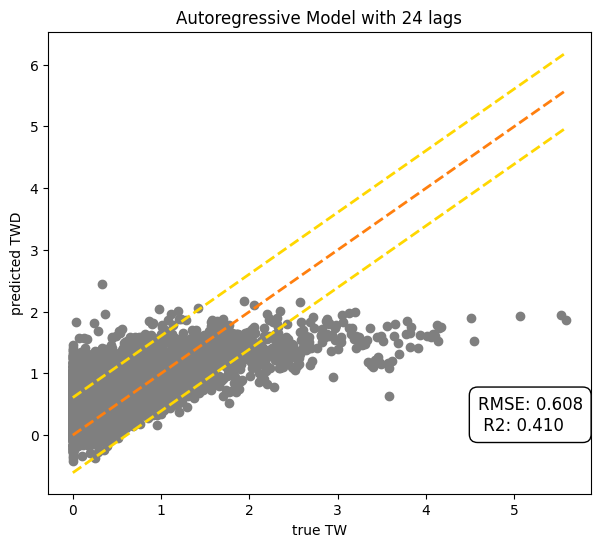

In [204]:
x_scatter = val_y
y_scatter = y_pred_val
rmse_scatter = rmse_val
plt.figure(figsize=(7,6))
plt.scatter(x =x_scatter, y =y_scatter, color = "tab:grey")
plt.xlabel("true TW")
plt.ylabel("predicted TWD")
x_range = [x_scatter.min(), x_scatter.max()]
# how to plot y= x? 
plt.plot(x_range,x_range, 'k--', 
lw=2, color = "tab:orange")
# can i plot two lines showing the rmse range?
plt.plot(x_range, [i+rmse_scatter for i in x_range], 'k--', 
lw=2, color = "gold")
plt.plot(x_range, [i-rmse_scatter for i in x_range], 'k--', 
lw=2, color = "gold")
plt.title(f"Autoregressive Model with {lag_n} lags")
plt.text(x_scatter.max()-1, y_scatter.min()+0.5, f"RMSE: {rmse_scatter:.3f}\n R2: {r2:.3f}", 
         fontsize=12, color="black",
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))


it looks like it randomly predict value within the range of 0-2

### autogressive model

In [205]:

rgr_at = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 2, 10]).fit(train_X_at, train_y_at)
rgr_at.score(train_X_at, train_y_at)

rmse_train_at = root_mean_squared_error(train_y_at, rgr_at.predict(train_X_at))

y_pred_val_at =rgr_at.predict(val_X_at) 
rmse_val_at = root_mean_squared_error(val_y_at,  y_pred_val_at)

r2_at = r2_score(val_y_at, y_pred_val_at)


In [206]:
rgr_at.alpha_

np.float64(10.0)

/scratch/tmp.47319990.taoj/ipykernel_1656472/2334290380.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_range,x_range, 'k--',
/scratch/tmp.47319990.taoj/ipykernel_1656472/2334290380.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_range, [i+rmse_scatter for i in x_range], 'k--',
/scratch/tmp.47319990.taoj/ipykernel_1656472/2334290380.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_range, [i-rmse_scatter for i in x_range], 'k--',


Text(4.58346527777778, 0.2747010898897145, 'RMSE: 0.263\n R2: 0.889')

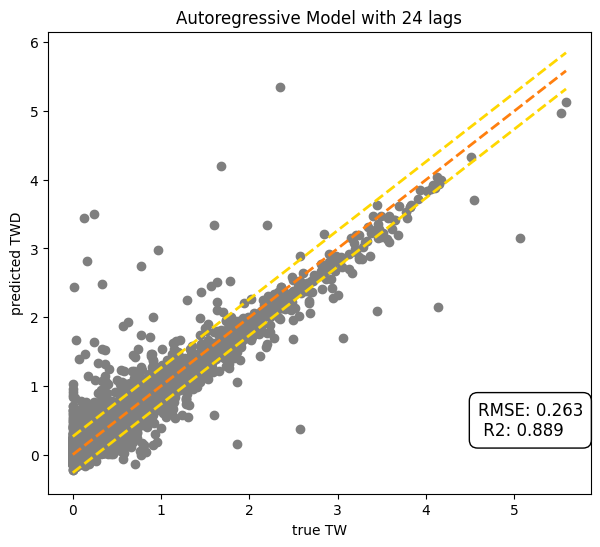

In [207]:
x_scatter = val_y_at
y_scatter = y_pred_val_at
rmse_scatter = rmse_val_at
r2_scatter = r2_at
plt.figure(figsize=(7,6))
plt.scatter(x =x_scatter, y =y_scatter, color = "tab:grey")
plt.xlabel("true TW")
plt.ylabel("predicted TWD")
x_range = [x_scatter.min(), x_scatter.max()]
# how to plot y= x? 
plt.plot(x_range,x_range, 'k--', 
lw=2, color = "tab:orange")
# can i plot two lines showing the rmse range?
plt.plot(x_range, [i+rmse_scatter for i in x_range], 'k--', 
lw=2, color = "gold")
plt.plot(x_range, [i-rmse_scatter for i in x_range], 'k--', 
lw=2, color = "gold")
plt.title(f"Autoregressive Model with {lag_n} lags")
plt.text(x_scatter.max()-1, y_scatter.min()+0.5, f"RMSE: {rmse_scatter:.3f}\n R2: {r2_at:.3f}", 
         fontsize=12, color="black",
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))


let's use ridge regression as a benchmark (baseline)

some example function can be borrowed from turorial: 
https://www.tensorflow.org/tutorials/structured_data/time_series

In [ ]:
w2.example = example_inputs, example_labels
def plot(self, model=None, plot_col='twd', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col}')
    plt.plot(self.input_indices, inputs[n,:, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n,:, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n,:, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [D]')

WindowGenerator.plot = plot

w2.plot(plot_col='twd')

In [ ]:
# def make_dataset(self, data):
#   data = np.array(data, dtype=np.float32)
#   ds = tf.keras.utils.timeseries_dataset_from_array(
#       data=data,
#       targets=None,
#       sequence_length=self.total_window_size,
#       sequence_stride=1,
#       shuffle=True,
#       batch_size=32,)

#   ds = ds.map(self.split_window)

#   return ds

# WindowGenerator.make_dataset = make_dataset